<a href="https://colab.research.google.com/github/SaltyRain/stock-prices-clustering-kmeans/blob/main/Stock_Market_Clustering_in_Python_Using_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Clustering in Python Using K-Means

In this project we will get the data for S&P500 stocks close prices for the last 3 years. 

Then we will cluster the data by annual mean returns and variances

And based on that data we will create a simple diversed portfolio.

## Step 1. Import libraries

In [ ]:
# Importing a library that is not in Colaboratory
!pip install datapackage
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import yfinance as yf
import datapackage
import scipy.stats as stats
plt.style.use('fivethirtyeight')

## Step 2. Import stocks data

In [ ]:
# Load the list of SP500 companies

data_url = 'https://datahub.io/core/s-and-p-500-companies/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        data = pd.read_csv(resource.descriptor['path'])

# Dropping stocks that crushes the program
data.drop(data.index[data['Symbol'] == "BRK.B"], inplace=True)
data.drop(data.index[data['Symbol'] == "UA"], inplace=True)
data.drop(data.index[data['Symbol'] == "WELL"], inplace=True)
data.drop(data.index[data['Symbol'] == "BF.B"], inplace=True)
data.drop(data.index[data['Symbol'] == "ZION"], inplace=True)

data

,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care
...,...,...,...
499,XYL,Xylem,Industrials
500,YUM,Yum! Brands,Consumer Discretionary
501,ZBRA,Zebra Technologies,Information Technology
502,ZBH,Zimmer Biomet,Health Care


For the 1st time we should download the data from Yahoo Finance using yfinance python package

In [ ]:
# Load the stock prices for each company
symbols = data['Symbol'].values.tolist()
df = pd.DataFrame()

for symbol in symbols:
  # Get the ticker data from Yahoo Finance
  ticker = yf.Ticker(symbol)
  # Get ticker's history close prices for the last 3 years
  hist = ticker.history(start="2018-01-01", end="2022-01-02").Close.to_frame()
  # Add ticker close price to the result Data Frame
  df[symbol] = hist['Close']

Then we can upload the data into csv file and in further work we can get the data from the local file

In [ ]:
# Save Data Frames to CSV files
path_prices = '/content/data/stocks_prices.csv'
with open(path_prices, 'w', encoding = 'utf-8-sig') as f1:
  df.to_csv(f1)

f1.close()

Upload the data from local csv file

In [ ]:
# Load the data from formed csv files
df = pd.read_csv('/content/stocks_prices.csv')
df.head()

,Date,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,AMD,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,...,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VIAC,VTRS,V,VNO,VMC,WRB,GWW,WAB,WBA,WMT,WM,WAT,WEC,WFC,WST,WDC,WU,WRK,WY,WHR,WMB,WLTW,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZTS
0,2018-01-02,207.509613,57.169456,54.864075,80.227051,192.490005,144.704498,62.751755,35.328030,177.699997,103.325127,10.98,9.477118,39.979996,65.523415,150.973145,65.559998,71.539894,123.973457,116.611557,224.619995,76.514236,37.111221,93.404869,1073.209961,1065.000000,53.570660,1189.010010,9.860753,52.403801,51.647564,62.668869,93.103210,52.874180,130.570328,82.840584,154.319305,87.759605,70.778038,157.511444,...,173.580002,208.186707,113.895287,75.725601,48.968491,109.470001,94.246765,44.403767,152.910004,63.559349,56.126579,42.805824,111.468178,61.587307,125.653549,43.035599,219.671707,80.913185,66.738945,91.389320,79.902527,195.690002,58.375267,53.879810,97.880219,74.649712,16.284010,56.565739,30.586054,148.193420,24.089083,139.826675,154.734451,43.253300,64.657593,64.942619,76.112846,103.709999,120.352028,69.990440
1,2018-01-03,207.500793,57.513245,54.985386,81.482513,195.820007,145.372360,63.727520,35.054840,181.039993,104.260109,11.55,9.468408,40.098156,67.190582,151.794067,65.940002,71.206093,124.218536,116.064102,231.199997,76.839767,36.785149,93.459854,1091.520020,1082.479980,53.373760,1204.199951,9.860753,52.134563,51.014030,62.140923,93.677231,53.460674,131.079163,82.254723,153.556396,88.086235,71.400681,160.483673,...,175.190002,210.370605,111.717873,76.125458,49.263489,110.900002,93.971390,43.491302,152.009995,63.012749,56.155041,42.835613,112.577896,61.412086,127.959480,42.679226,218.292404,80.259483,67.237610,92.186523,81.062546,197.770004,58.171143,54.294334,97.998283,75.833038,16.275475,57.168884,30.854650,148.943253,24.754358,142.442657,153.058090,42.963799,65.953041,65.734489,76.047546,105.769997,121.186333,70.312263
2,2018-01-04,210.213104,57.782688,54.892078,81.017830,199.250000,147.093658,63.093281,35.645264,183.220001,108.107178,12.12,9.433565,40.511719,66.686554,152.377899,65.599998,70.433556,122.738724,113.748566,233.300003,77.912170,36.353306,92.378456,1095.760010,1086.400024,53.161713,1209.589966,9.860753,51.542225,51.335663,61.405277,95.235367,53.673946,129.164047,81.473541,154.119446,87.890259,71.974709,159.807419,...,172.000000,211.283722,111.126724,76.370255,48.058937,111.470001,94.443459,43.632320,153.070007,64.447571,55.016754,43.997356,112.996452,59.580070,127.092392,42.851269,219.997864,81.342491,63.755974,92.269951,81.758553,199.660004,57.966999,54.973454,97.968758,75.374367,16.599787,58.602482,30.603386,148.925659,25.179821,143.888550,153.886841,42.629055,67.143723,66.173347,76.821739,107.860001,121.011703,70.731613
3,2018-01-05,211.851059,58.525990,55.050720,82.428185,202.320007,148.307022,64.761841,35.407330,185.339996,109.256409,11.88,9.468408,40.779865,67.752769,153.654907,65.830002,70.328651,124.152557,113.981895,241.070007,78.103668,36.203491,93.359032,1110.290039,1102.229980,53.313194,1229.140015,9.860753,51.506321,51.316174,61.275463,95.452560,53.896111,129.996704,80.673782,154.646225,88.954132,71.789841,160.759552,...,171.380005,215.312622,110.318810,76.729301,47.813110,113.000000,95.279419,43.532776,155.690002,64.652565,54.618370,44.225735,115.702621,60.089828,125.682144,42.673088,222.038879,79.839951,64.931328,92.816849,81.656456,202.229996,57.576466,55.343891,99.198402,75.851364,17.581268,58.838497,30.560057,148.625687,25.110201,144.811310,154.913391,42.330505,70.629974,66.049324,77.269447,109.540001,122.214668,71.541039
4,2018-01-08,211.164169,58.804726,54.892078,81.107498,207.800003,149.492233,65.015541,35.328030,185.039993,108.487015,12.28,9.468408,40.884388,67.898170,153.819107,65.879997,69.384453,129.553345,114.233208,248.899994,77.787697,36.608883,92.919151,1114.209961,1106.939941,53.245022,1246.869995,9.860753,52.116608,50.809349,61.8120

In [ ]:
# Set the date as the index
df = df.set_index(pd.DatetimeIndex(df['Date'].values))
#Remove the Date column
df.drop(columns=['Date'], axis=1, inplace=True)

df.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,AMD,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,...,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VIAC,VTRS,V,VNO,VMC,WRB,GWW,WAB,WBA,WMT,WM,WAT,WEC,WFC,WST,WDC,WU,WRK,WY,WHR,WMB,WLTW,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZTS
2018-01-02,207.509613,57.169456,54.864075,80.227051,192.490005,144.704498,62.751755,35.328030,177.699997,103.325127,10.98,9.477118,39.979996,65.523415,150.973145,65.559998,71.539894,123.973457,116.611557,224.619995,76.514236,37.111221,93.404869,1073.209961,1065.000000,53.570660,1189.010010,9.860753,52.403801,51.647564,62.668869,93.103210,52.874180,130.570328,82.840584,154.319305,87.759605,70.778038,157.511444,42.232319,...,173.580002,208.186707,113.895287,75.725601,48.968491,109.470001,94.246765,44.403767,152.910004,63.559349,56.126579,42.805824,111.468178,61.587307,125.653549,43.035599,219.671707,80.913185,66.738945,91.389320,79.902527,195.690002,58.375267,53.879810,97.880219,74.649712,16.284010,56.565739,30.586054,148.193420,24.089083,139.826675,154.734451,43.253300,64.657593,64.942619,76.112846,103.709999,120.352028,69.990440
2018-01-03,207.500793,57.513245,54.985386,81.482513,195.820007,145.372360,63.727520,35.054840,181.039993,104.260109,11.55,9.468408,40.098156,67.190582,151.794067,65.940002,71.206093,124.218536,116.064102,231.199997,76.839767,36.785149,93.459854,1091.520020,1082.479980,53.373760,1204.199951,9.860753,52.134563,51.014030,62.140923,93.677231,53.460674,131.079163,82.254723,153.556396,88.086235,71.400681,160.483673,42.780663,...,175.190002,210.370605,111.717873,76.125458,49.263489,110.900002,93.971390,43.491302,152.009995,63.012749,56.155041,42.835613,112.577896,61.412086,127.959480,42.679226,218.292404,80.259483,67.237610,92.186523,81.062546,197.770004,58.171143,54.294334,97.998283,75.833038,16.275475,57.168884,30.854650,148.943253,24.754358,142.442657,153.058090,42.963799,65.953041,65.734489,76.047546,105.769997,121.186333,70.312263
2018-01-04,210.213104,57.782688,54.892078,81.017830,199.250000,147.093658,63.093281,35.645264,183.220001,108.107178,12.12,9.433565,40.511719,66.686554,152.377899,65.599998,70.433556,122.738724,113.748566,233.300003,77.912170,36.353306,92.378456,1095.760010,1086.400024,53.161713,1209.589966,9.860753,51.542225,51.335663,61.405277,95.235367,53.673946,129.164047,81.473541,154.119446,87.890259,71.974709,159.807419,42.631546,...,172.000000,211.283722,111.126724,76.370255,48.058937,111.470001,94.443459,43.632320,153.070007,64.447571,55.016754,43.997356,112.996452,59.580070,127.092392,42.851269,219.997864,81.342491,63.755974,92.269951,81.758553,199.660004,57.966999,54.973454,97.968758,75.374367,16.599787,58.602482,30.603386,148.925659,25.179821,143.888550,153.886841,42.629055,67.143723,66.173347,76.821739,107.860001,121.011703,70.731613
2018-01-05,211.851059,58.525990,55.050720,82.428185,202.320007,148.307022,64.761841,35.407330,185.339996,109.256409,11.88,9.468408,40.779865,67.752769,153.654907,65.830002,70.328651,124.152557,113.981895,241.070007,78.103668,36.203491,93.359032,1110.290039,1102.229980,53.313194,1229.140015,9.860753,51.506321,51.316174,61.275463,95.452560,53.896111,129.996704,80.673782,154.646225,88.954132,71.789841,160.759552,43.151031,...,171.380005,215.312622,110.318810,76.729301,47.813110,113.000000,95.279419,43.532776,155.690002,64.652565,54.618370,44.225735,115.702621,60.089828,125.682144,42.673088,222.038879,79.839951,64.931328,92.816849,81.656456,202.229996,57.576466,55.343891,99.198402,75.851364,17.581268,58.838497,30.560057,148.625687,25.110201,144.811310,154.913391,42.330505,70.629974,66.049324,77.269447,109.540001,122.214668,71.541039
2018-01-08,211.164169,58.804726,54.892078,81.107498,207.800003,149.492233,65.015541,35.328030,185.039993,108.487015,12.28,9.468408,40.884388,67.898170,153.819107,65.879997,69.384453,129.553345,114.233208,248.899994,77.787697,36.608883,92.919151,1114.209961,1106.939941,53.245022,1246.869995,9.86075

## Step 3. Calculate the annual mean returns and variance

In [ ]:
# Calculate the annual mean returns and variance
daily_returns = df.pct_change()

# There are ± 252 trading days in the year, so we multiply on this value
annual_mean_returns = daily_returns.mean() * 252
annual_return_variance = daily_returns.var() * 252

In [ ]:
# Create a new dataframe
df2 = pd.DataFrame(df.columns, columns=['Stock_Symbols'])
df2['Variances'] = annual_return_variance.values
df2['Returns'] = annual_mean_returns.values

df2

,Stock_Symbols,Variances,Returns
0,MMM,0.073438,-0.001929
1,AOS,0.088722,0.145128
2,ABT,0.071958,0.270933
3,ABBV,0.089835,0.173863
4,ABMD,0.199770,0.259010
...,...,...,...
495,XYL,0.094768,0.200902
496,YUM,0.072625,0.186087
497,ZBRA,0.157642,0.515725
498,ZBH,0.103229,0.064801


## Step 4. Modeling the data

We use the Elbow method to determine the number of clusters to use to group the stocks

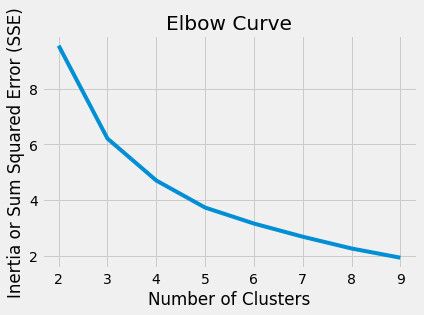

In [ ]:
# Use the Elbow method to determine the number of clusters to use to group the stocks
# Get and store the annual returns and annual variances

X = df2[['Returns', 'Variances']].values
inertia_list = []
for k in range(2,10):
  # Create and traing the model
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  inertia_list.append(kmeans.inertia_)


# Plot the data
plt.plot(range(2,10), inertia_list)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia or Sum Squared Error (SSE)')
plt.show()

In [ ]:
# Get and show the labels / groups for each stock in set

kmeans = KMeans(n_clusters=3).fit(X)
labels = kmeans.labels_
labels

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 2, 1, 1, 1, 0, 1, 2,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 0, 0, 1, 1,
       0, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,

In [ ]:
df2['Cluster_Labels'] = labels
df2

,Stock_Symbols,Variances,Returns,Cluster_Labels
0,MMM,0.073438,-0.001929,1
1,AOS,0.088722,0.145128,1
2,ABT,0.071958,0.270933,0
3,ABBV,0.089835,0.173863,1
4,ABMD,0.199770,0.259010,0
...,...,...,...,...
495,XYL,0.094768,0.200902,1
496,YUM,0.072625,0.186087,1
497,ZBRA,0.157642,0.515725,0
498,ZBH,0.103229,0.064801,1


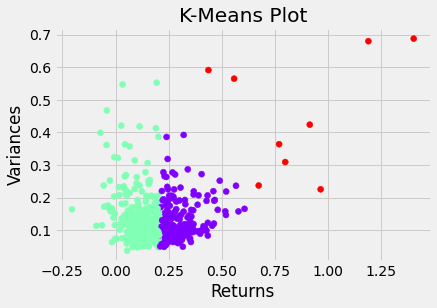

In [ ]:
# Plot and show the different clusters
plt.scatter(X[:,0], X[:,1], c = labels, cmap = 'rainbow')
plt.title('K-Means Plot')
plt.xlabel('Returns')
plt.ylabel('Variances')
plt.show()

In [ ]:
# Create a function to build a simple diversed portfolio
def diversed_port():
  for i in range(0, 3):
    symbol = df2[df2['Cluster_Labels'] == i].head(3)
    print(symbol[['Stock_Symbols', 'Cluster_Labels']])


diversed_port()

  Stock_Symbols  Cluster_Labels
2           ABT               0
4          ABMD               0
5           ACN               0
  Stock_Symbols  Cluster_Labels
0           MMM               1
1           AOS               1
3          ABBV               1
   Stock_Symbols  Cluster_Labels
10           AMD               2
81           CZR               2
87          CARR               2
